# Import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 데이터 Load

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


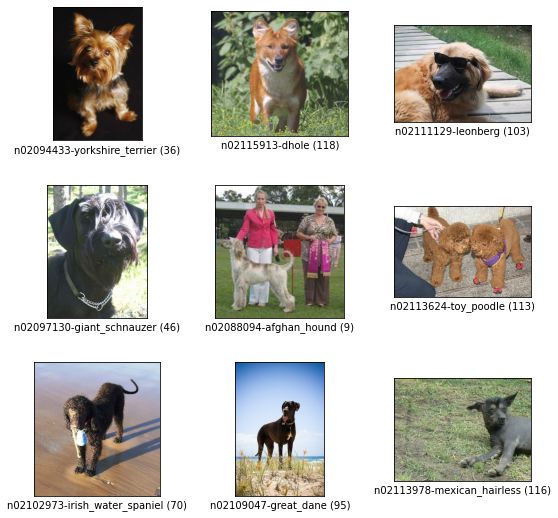

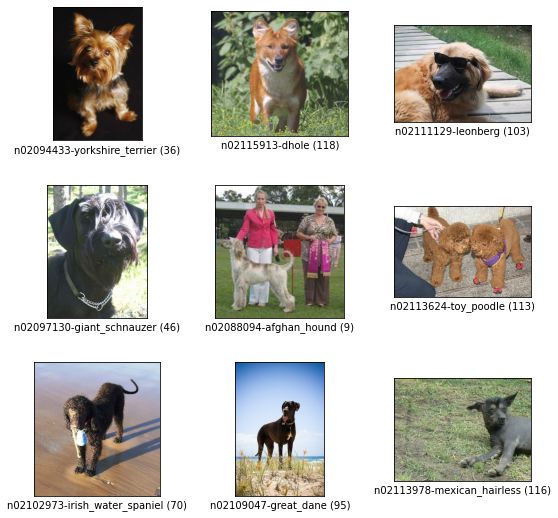

In [4]:
tfds.show_examples(ds_train, ds_info)

# Data Augmentation

- normalization, basic augmentation

In [13]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label,num_classes=120):
    label = tf.one_hot(label, num_classes)
    return image, label

- cutmix

In [5]:
# clipbox
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [6]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [7]:
# mix two labels
def mix_2_labels(image_a,image_b,label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [8]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a,image_b,label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

- mixup

In [15]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b,num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [10]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

- augmentation적용 함수

In [11]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [16]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

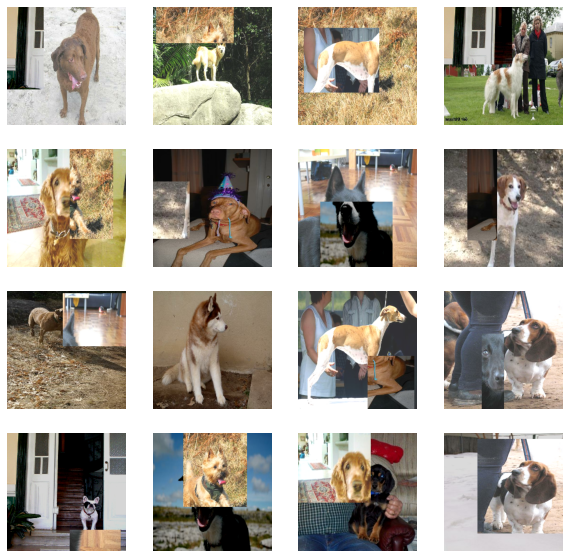

In [34]:
# cutmix image 확인
plt.figure(figsize=(10, 10))
for images, labels in ds_train_cutmix.take(2):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.axis("off")

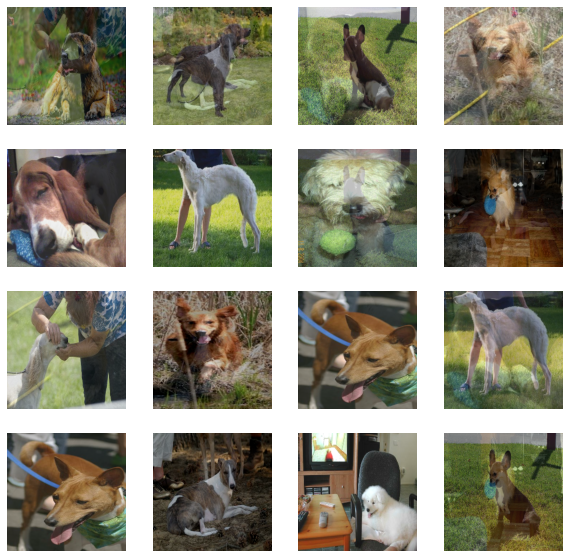

In [32]:
# mixup image 확인
plt.figure(figsize=(10, 10))
for images, labels in ds_train_mixup.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.axis("off")

# 모델 구성

- no augmentation

In [13]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


- basic augmentation only

In [14]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

- Aug + cutmix

In [86]:
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

- Aug + mixup

In [88]:
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Training

- No augmentation

In [83]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 210s 210ms/step - loss: 2.2175 - accuracy: 0.4460 - val_loss: 3.4183 - val_accuracy: 0.1997
Epoch 2/20
750/750 [==============================] - 155s 206ms/step - loss: 0.7106 - accuracy: 0.8045 - val_loss: 1.1074 - val_accuracy: 0.6831
Epoch 3/20
750/750 [==============================] - 155s 206ms/step - loss: 0.2166 - accuracy: 0.9550 - val_loss: 0.9630 - val_accuracy: 0.7221
Epoch 4/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0653 - accuracy: 0.9948 - val_loss: 0.9093 - val_accuracy: 0.7418
Epoch 5/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0290 - accuracy: 0.9985 - val_loss: 0.9333 - val_accuracy: 0.7364
Epoch 6/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0184 - accuracy: 0.9992 - val_loss: 0.9402 - val_accuracy: 0.7409
Epoch 7/20
750/750 [==============================] - 155s 206ms/step - loss: 0.0127 - accuracy: 0.9997 - val_loss: 0.9500 -

- basic augmentation

In [84]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 159s 203ms/step - loss: 2.2452 - accuracy: 0.4385 - val_loss: 2.8253 - val_accuracy: 0.3022
Epoch 2/20
750/750 [==============================] - 152s 203ms/step - loss: 0.9397 - accuracy: 0.7328 - val_loss: 1.2651 - val_accuracy: 0.6244
Epoch 3/20
750/750 [==============================] - 152s 203ms/step - loss: 0.4912 - accuracy: 0.8638 - val_loss: 1.0755 - val_accuracy: 0.6899
Epoch 4/20
750/750 [==============================] - 152s 203ms/step - loss: 0.2597 - accuracy: 0.9397 - val_loss: 1.0179 - val_accuracy: 0.7037
Epoch 5/20
750/750 [==============================] - 154s 206ms/step - loss: 0.1445 - accuracy: 0.9714 - val_loss: 0.9806 - val_accuracy: 0.7168
Epoch 6/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0859 - accuracy: 0.9860 - val_loss: 0.9611 - val_accuracy: 0.7310
Epoch 7/20
750/750 [==============================] - 155s 206ms/step - loss: 0.0551 - accuracy: 0.9939 - val_loss: 0.9688 -

- Aug + cutmix

In [87]:
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = aug_cutmix_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 165s 209ms/step - loss: 3.8421 - accuracy: 0.2057 - val_loss: 3.0878 - val_accuracy: 0.2359
Epoch 2/20
750/750 [==============================] - 156s 208ms/step - loss: 3.0191 - accuracy: 0.4036 - val_loss: 1.4646 - val_accuracy: 0.6005
Epoch 3/20
750/750 [==============================] - 156s 207ms/step - loss: 2.7492 - accuracy: 0.4865 - val_loss: 1.3414 - val_accuracy: 0.6257
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 2.5535 - accuracy: 0.5529 - val_loss: 1.2531 - val_accuracy: 0.6500
Epoch 5/20
750/750 [==============================] - 155s 207ms/step - loss: 2.3970 - accuracy: 0.6013 - val_loss: 1.1656 - val_accuracy: 0.6733
Epoch 6/20
750/750 [==============================] - 156s 207ms/step - loss: 2.3032 - accuracy: 0.6316 - val_loss: 1.2340 - val_accuracy: 0.6636
Epoch 7/20
750/750 [==============================] - 156s 207ms/step - loss: 2.2235 - accuracy: 0.6593 - val_loss: 1.1475 -

- aug + mixup

In [89]:
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = aug_mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 164s 209ms/step - loss: 3.7444 - accuracy: 0.2333 - val_loss: 3.7439 - val_accuracy: 0.1589
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 2.9570 - accuracy: 0.4499 - val_loss: 1.6482 - val_accuracy: 0.5491
Epoch 3/20
750/750 [==============================] - 156s 207ms/step - loss: 2.6829 - accuracy: 0.5483 - val_loss: 1.3831 - val_accuracy: 0.6179
Epoch 4/20
750/750 [==============================] - 156s 207ms/step - loss: 2.5009 - accuracy: 0.6008 - val_loss: 1.6710 - val_accuracy: 0.5461
Epoch 5/20
750/750 [==============================] - 156s 207ms/step - loss: 2.3943 - accuracy: 0.6489 - val_loss: 1.4682 - val_accuracy: 0.6087
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 2.3129 - accuracy: 0.6845 - val_loss: 1.1485 - val_accuracy: 0.6782
Epoch 7/20
750/750 [==============================] - 156s 207ms/step - loss: 2.2190 - accuracy: 0.7106 - val_loss: 1.4540 -

# Augmentation에 의한 모델 성능 비교

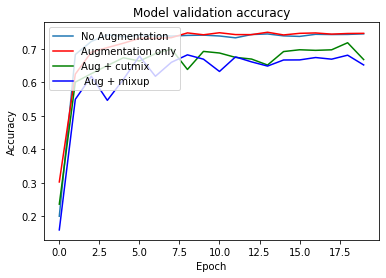

In [91]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'])
plt.plot(history_resnet50_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation only', 'Aug + cutmix', ' Aug + mixup'], loc='upper left')
plt.show()

첫 번째 모델 : Augmentation 적용 x\
두 번째 모델 : normalization과 flip, bright만 조절\
세 번째 모델 : 위 basic Augmentation과 cutmix 적용\
네 번째 모델 : 위 basic Augmentation과 mixup 적용



단순히 데이터에 flip을 가하고 bright만 조절한 augmentation같은 경우 정확도가\
augmetation을 적용하지 않은 경우와 비슷하나 조금 더 좋아진 것으로 보입니다.\
하지만 cutmix와 mixup까지 적용한 경우 오히려 정확도가 0.1정도 떨어졌습니다.

basic augmentation시에는 Label 값에 영향을 주지는 않습니다.
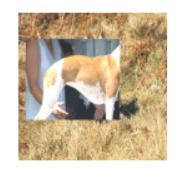
하지만 위의 사진과 같이 잘라온 사진이 판단에 중요한 부분을 가릴 경우\
단순히 이미지 전체 크기와 잘라온 크기의 비율만으로 레이블 값을 조정하기 때문에\
강아지가 있는 부분이 얼마나 가려져있는 지는 클래스 값에 영향을 줄 수 없습니다.
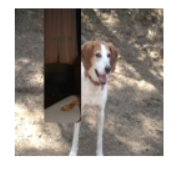
위의 그림은 잘라온 사진에 대상 객체가 없습니다. 잘라온 사진의 레이블 값도 합쳐진 그림의 레이블에 영향을 주기 때문에\
오히려 노이즈로 작용하는 것으로 보입니다.\
밑에 사진도 윗 사진과 동일합니다.
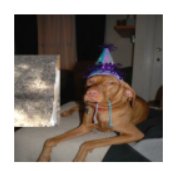

